In [1]:
import numpy as np
import numpy.linalg as la
from scipy import spatial
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib inline

$$\phi(x) = (1+a_0) x^2/2 + a_1 x - a_2 \exp \left( - \frac{1}{2} [a_3(x+a_4)]^2 \right)$$ yielding
$$
T(x) =  (1+a_0) x + a_1 + a_2 a_3^2 (x+a_4) \exp \left( - \frac{1}{2}[a_3(x+a_4)]^2 \right)\\
 = T_0(x) + T_1(x)
$$
and  
$$
g(z) =\frac{1}{2} \beta_0 z^2 + \beta_1 z + \beta_2 + \beta_3 \exp \left( -\frac{1}{2}[\beta_4(z+\beta_5)]^2 \right) + \beta_6 \exp \left( -\frac{1}{2}[\beta_7(z+\beta_8)]^2 \right) \\
 = g_0(z) + g_1(z) + g_2(z)
$$

Penalization:
$\beta_0,..,\beta_3$ and $\beta_6$: unpenalized. $\beta_4, \beta_7$: penalized as $\sim \exp((\epsilon \beta_j)^2)$. $\beta_5, \beta_8$ penalized as $\sim (\beta_k/D)^2$.

$a_0$ penalized as $\sim a_0^2$. $a_1,a_4$ penalized as $\sim (a_i/D)^2$. $a_2$ penalized as $a_2^2$ and $a_3$ penalized as $\sim \exp((\epsilon a_3)^2)$.

where $D$ is an estimate of the size of the support of the data (e.g. std), $\epsilon = \max_i \min_j |x_i-y_j|$

# Data samples

In [2]:
Nx = 500
Ny = 490

#Guassians
x = np.random.normal(0,1,Nx)
y = np.random.normal(-1,1,Ny)

#Gaussian to mixed Gaussian
x = np.random.normal(0,1,Nx)
y1 = np.random.normal(-1.0,0.75,int(Ny/2))
y2 = np.random.normal(1.0,0.75,int(Ny/2))
y = np.concatenate([y1,y2],axis=0)

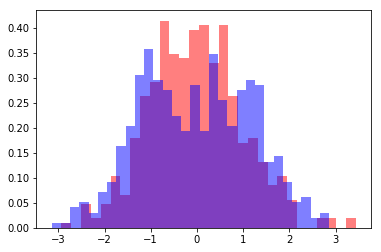

In [13]:
bins = 30
plt.hist(x,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

# Local Algorithm

## GH

In [4]:
try:
    Nx,d = x.shape
except ValueError:
    Nx = len(x)
    d = 1
Ny = len(y)
da = 2+2*d+d**2
db = 3*d+6

#Precomputed data, (twisted) gradient and Hessian
xh = np.concatenate([x.reshape(Nx,d),np.ones((Nx,d))],axis=1)

gammaA = 2*1e-1 #alpha regularization parameter 
gammaB = 2*1e-1 #beta regularization parameter

def GH(a,b,eps,D):

    #precomputations
    Tx0 = (1+a[0])*x+a[1] 
    xa4 = x + a[4]
    a3xa4 = a[3]*xa4
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = a[2]*a[3]*a3xa4*expo
    Tx = Tx0 + Tx1
    
    g0y = 0.5*b[0]*y**2 + b[1]*y + b[2]
    argexpy1 =  (b[4]*(y + b[5]))**2
    expoy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  (b[7]*(y + b[8]))**2
    expoy2 = np.exp(-0.5*argexpy2)
    g1y = b[3]*expoy1
    g2y = b[6]*expoy2
    gy = g0y + g1y + g2y
    g0Tx = 0.5*b[0]*Tx**2 + b[1]*Tx + b[2]
    argexpT1 =  (b[4]*(Tx + b[5]))**2
    expoT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  (b[7]*(Tx + b[8]))**2
    expoT2 = np.exp(-0.5*argexpT2)
    g1Tx = b[3]*expoT1
    g2Tx = b[6]*expoT2
    gTx = g0Tx + g1Tx + g2Tx   
    
    g0pTx = b[0]*Tx + b[1]
    g1pTx = -b[4]**2 * (Tx+b[5])*g1Tx
    g2pTx = -b[7]**2 * (Tx+b[8])*g2Tx
    gpTx = g0pTx + g1pTx + g2pTx
    
    daT = np.zeros((Nx,da))
    daT[:,0] = x
    daT[:,1] = np.ones(Nx)
    daT[:,2] = expo*a[3]*a3xa4
    daT[:,3] = a[2] * a3xa4 * expo * (2.0 - a3xa42)
    daT[:,4] = a[2]*a[3]**2 * expo * (1.0 - a3xa42)

    #gradient w.r.t. a
    penalty_a = np.array([0*a[0],0*a[1]/D**2,0*a[2],eps**2*a[3]*np.exp((eps*a[3])**2)-1.0/(D**2 * a[3]**3),1*a[4]/(10*D**2)]) 
    daL = (1.0/Nx) * np.einsum('i,ik->k',gpTx,daT) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penalty_a

    expgy = np.exp(gy)
    dbgy = np.zeros((Ny,db))
    dbgT = np.zeros((Nx,db))
    dbgy[:,0] = 0.5*y**2
    dbgT[:,0] = 0.5*Tx**2
    dbgy[:,1] = y
    dbgT[:,1] = Tx
    dbgy[:,2] = np.ones(Ny)
    dbgT[:,2] = np.ones(Nx) 
    dbgy[:,3] = expoy1
    dbgT[:,3] = expoT1
    dbgy[:,4] = -b[4]*(y+b[5])**2 * g1y
    dbgT[:,4] = -b[4]*(Tx+b[5])**2 * g1Tx
    dbgy[:,5] = -b[4]**2 * (y+b[5])*g1y
    dbgT[:,5] = -b[4]**2 * (Tx+b[5])*g1Tx
    dbgy[:,6] = expoy2
    dbgT[:,6] = expoT2
    dbgy[:,7] = -b[7]*(y+b[8])**2 * g2y
    dbgT[:,7] = -b[7]*(Tx+b[8])**2 * g2Tx
    dbgy[:,8] = -b[7]**2 * (y+b[8])*g2y
    dbgT[:,8] = -b[7]**2 * (Tx+b[8])*g2Tx
    #gradient w.r.t. b
    penalty_b = np.array([0,0,0,0,eps**2*b[4]*np.exp((eps*b[4])**2)-1*1/(D**2 *b[4]**3),1*b[5]/(10*D**2)-1*2*eps**2 *(b[5]-b[8])**(-3),0,eps**2*b[7]*np.exp((eps*b[7])**2)-1*1/(D**2 *b[7]**3),1*b[8]/(10*D**2)+ 1*2*eps**2 *(b[5]-b[8])**(-3)])
    dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

    #twisted gradient
    G = np.concatenate([daL,-dbL],axis=0)

    g0ppTx = b[0]*np.ones(Nx)
    g1ppTx = -b[4]**2 *g1Tx*(1.0-b[4]**2 * (Tx+b[5]))
    g2ppTx = -b[7]**2 *g2Tx*(1.0-b[7]**2 * (Tx+b[8]))
    gppTx = g0ppTx+g1ppTx+g2ppTx
    
    daaT = np.zeros((Nx,da,da))
    daaT[:,2,3] = a3xa4 * expo * (2.0 - a3xa42)
    daaT[:,2,4] = a[3]**2 * expo * (1.0 - a3xa42)
    daaT[:,3,3] = a[2] * xa4 * expo * (2.0-3*a3xa42-a3xa42*(2.0-a3xa42))
    daaT[:,3,4] = a[2]*a[3] * expo * (2.0 + a3xa42*(a3xa42-5.0))
    daaT[:,4,4] = -a[2]*a[3]**4 *xa4 * expo * (3.0 + a3xa42)
    #Hessian w.r.t. aa
#     penaltyH_a = np.eye(da)
#     penaltyH_a[1,1] = 1.0/D**2
    penaltyH_a = np.zeros((da,da))
    penaltyH_a[4,4] = 1*1.0/(10*D**2)
    penaltyH_a[3,3] = eps**2 * np.exp((a[3]*eps)**2)*(1.0+2.0*a[3]*eps**2) + 3/(D**2 * a[3]**4)
    daaL = (1.0/Nx)*(np.einsum('i,ikl->kl',gpTx,daaT) + np.einsum('i,ik,il->kl',gppTx,daT,daT)) + gammaA*(0.00+(1/Nx)*la.norm(gpTx))*penaltyH_a

    dbgpTx = np.zeros((Nx,db))
    dbgpTx[:,0] = Tx
    dbgpTx[:,1] = np.ones(Nx)
    dbgpTx[:,3] = -b[4]**2 * (Tx+b[5]) * expoT1
    dbgpTx[:,4] = b[4]*b[3]*(Tx+b[5])*expoT1*(-2.0+b[4]**2 * (Tx+b[5])**2)
    dbgpTx[:,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
    dbgpTx[:,6] = -b[7]**2 * (Tx+b[8]) * expoT2
    dbgpTx[:,7] = b[7]*b[6]*(Tx+b[8])*expoT2*(-2.0+b[7]**2 * (Tx+b[8])**2)
    dbgpTx[:,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
    
    #Hessian w.r.t. ab
    dabL = (1.0/Nx)*np.einsum('in,ik->kn',dbgpTx,daT)

    dbbgy = np.zeros((Ny,db,db))
    dbbgT = np.zeros((Nx,db,db))
    dbbgy[:,3,4] = -b[4]*(y+b[5])**2 * expoy1
    dbbgT[:,3,4] = -b[4]*(Tx+b[5])**2 * expoT1
    dbbgy[:,3,5] = -b[4]**2 * (y+b[5])* expoy1
    dbbgT[:,3,5] = -b[4]**2 * (Tx+b[5])* expoT1
    dbbgy[:,4,4] = b[3]*(y+b[5])**2 * expoy1 * (-1.0+argexpy1)
    dbbgT[:,4,4] = b[3]*(Tx+b[5])**2 * expoT1 * (-1.0+argexpT1)
    dbbgy[:,4,5] = b[3]*b[4]*(y+b[5])*expoy1*(-2.0+b[4]*(y+b[5]))
    dbbgT[:,4,5] = b[3]*b[4]*(Tx+b[5])*expoT1*(-2.0+b[4]*(Tx+b[5]))
    dbbgy[:,5,5] = b[3]*b[4]**2 * expoy1*(-1.0+argexpy1)
    dbbgT[:,5,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
    dbbgy[:,6,7] = -b[7]*(y+b[8])**2 * expoy2
    dbbgT[:,6,7] = -b[7]*(Tx+b[8])**2 * expoT2
    dbbgy[:,6,8] = -b[7]**2 * (y+b[8])* expoy2
    dbbgT[:,6,8] = -b[7]**2 * (Tx+b[8])* expoT2
    dbbgy[:,7,7] = b[6]*(y+b[8])**2 * expoy2 * (-1.0+argexpy2)
    dbbgT[:,7,7] = b[6]*(Tx+b[8])**2 * expoT2 * (-1.0+argexpT2)
    dbbgy[:,7,8] = b[6]*b[7]*(y+b[8])*expoy2*(-2.0+b[7]*(y+b[8]))
    dbbgT[:,7,8] = b[6]*b[7]*(Tx+b[8])*expoT2*(-2.0+b[7]*(Tx+b[8]))
    dbbgy[:,8,8] = b[6]*b[7]**2 * expoy2*(-1.0+argexpy2)
    dbbgT[:,8,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
    #symmetrize tensors
    dbbgy = dbbgy + np.transpose(dbbgy,(0,2,1))
    dbbgy[:,np.arange(db),np.arange(db)] *= 0.5
    dbbgT = dbbgT + np.transpose(dbbgT,(0,2,1))
    dbbgT[:,np.arange(db),np.arange(db)] *= 0.5

    dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
    #Hessian w.r.t. bb
    penaltyH_b = np.zeros((db,db))
    penaltyH_b[5,5] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[8,8] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[5,8] = -1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[8,5] = -1*6*eps**2 *(b[5]-b[8])**(-4)
    penaltyH_b[4,4] = eps**2 * np.exp((b[4]*eps)**2)*(1.0+2.0*b[4]*eps**2) + 1*3/(D**2 * b[4]**4)
    penaltyH_b[7,7] = eps**2 * np.exp((b[7]*eps)**2)*(1.0+2.0*b[7]*eps**2) + 1*3/(D**2 * b[7]**4)
    dbbL = (1.0/Nx)*np.sum(dbbgT,axis=0) - (1.0/Ny)*np.einsum('jnm,j->nm',(dbbgy+dbgdbg),expgy) - gammaB*penaltyH_b

    #Twisted Hessian
    H = np.zeros((da+db,da+db))
    H[:da,:da] = daaL
    H[:da,da:] = dabL
    H[da:,:da] = -dabL.T
    H[da:,da:] = -dbbL
    return(G,H)

/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide


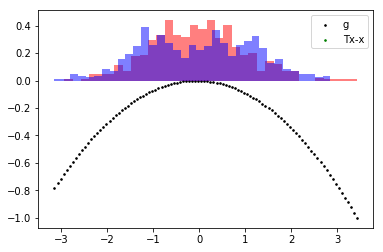

a= [0.         0.         0.         0.91177852 0.        ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.30822199 -0.01675513 -0.00030967] b0z^2+b1z+b2
b gauss1= [ 0.          0.91177852 -0.07507789] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.         0.91177852 0.1438299 ] b6exp(-(b7(z+b8))^2/2)
Step n= 0


/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:138: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/monty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


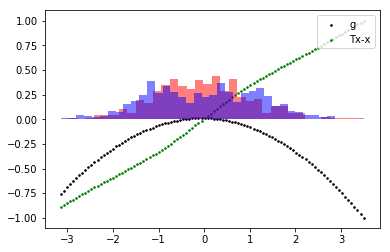

a= [1.56085323e-02 3.86700911e-04 5.27386903e-03 9.11872587e-01
 0.00000000e+00] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.30578673 -0.01675734  0.00764192] b0z^2+b1z+b2
b gauss1= [ 0.00729535  0.91835522 -0.10963401] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.00740299 0.91835606 0.17833418] b6exp(-(b7(z+b8))^2/2)
Step n= 1


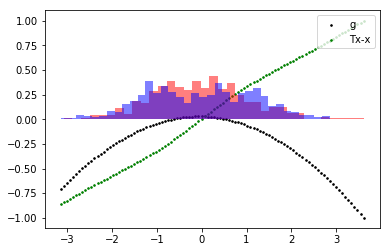

a= [4.96252601e-02 1.14890954e-03 1.69130636e-02 9.12143895e-01
 2.46995437e-06] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.2982792  -0.01668939  0.02131191] b0z^2+b1z+b2
b gauss1= [ 0.01898392  0.93253379 -0.15350962] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.0194007  0.93254121 0.22211991] b6exp(-(b7(z+b8))^2/2)
Step n= 2


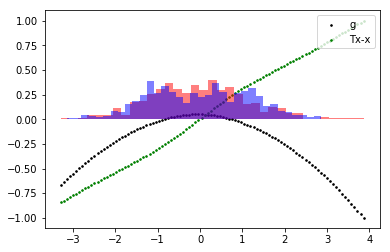

a= [1.21810018e-01 2.53735447e-03 4.20413948e-02 9.13003478e-01
 2.01086959e-05] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.27064056 -0.01642422  0.04023686] b0z^2+b1z+b2
b gauss1= [ 0.03091523  0.96042293 -0.20780803] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.03223678 0.96045208 0.27627862] b6exp(-(b7(z+b8))^2/2)
Step n= 3


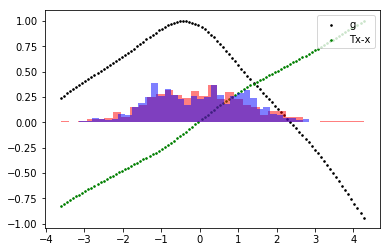

a= [2.35532346e-01 1.46151927e-02 8.77256230e-02 9.20307333e-01
 3.66989989e-04] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.00513734 -0.00504774  0.02598969] b0z^2+b1z+b2
b gauss1= [ 0.00247688  1.08846132 -0.28560935] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.01545157 1.08840949 0.35163782] b6exp(-(b7(z+b8))^2/2)
Step n= 4


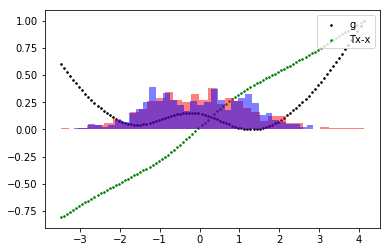

a= [0.19125531 0.01607219 0.09743435 0.9249922  0.00161345] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.0344383   0.00160359 -0.05988601] b0z^2+b1z+b2
b gauss1= [ 0.03855944  1.20390762 -0.38104991] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.06898135 1.20504144 0.44287451] b6exp(-(b7(z+b8))^2/2)
Step n= 5


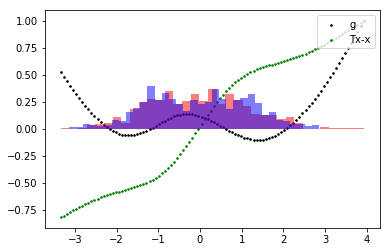

a= [0.13779552 0.01033065 0.1985447  0.95305405 0.00874888] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.06372324  0.00425028 -0.15655451] b0z^2+b1z+b2
b gauss1= [ 0.09423915  1.31955333 -0.49276237] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.15616434 1.31928299 0.53912651] b6exp(-(b7(z+b8))^2/2)
Step n= 6


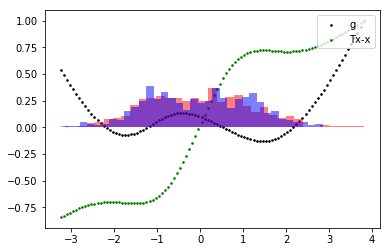

a= [0.10460214 0.00438062 0.27162453 0.98857174 0.01992126] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.07220099  0.00286989 -0.18445487] b0z^2+b1z+b2
b gauss1= [ 0.11847192  1.3827963  -0.5659236 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.18617466 1.378102   0.60437686] b6exp(-(b7(z+b8))^2/2)
Step n= 7


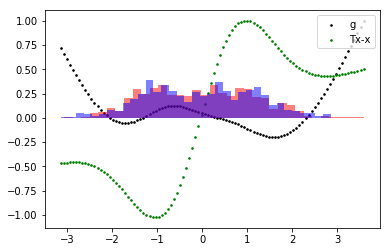

a= [ 0.0430322  -0.00217263  0.41598678  1.06403586  0.04037539] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.06657084 -0.00484772 -0.17246106] b0z^2+b1z+b2
b gauss1= [ 0.12574671  1.45829637 -0.6302531 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.16325218 1.44664954 0.67660446] b6exp(-(b7(z+b8))^2/2)
Step n= 8


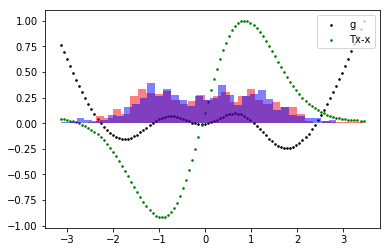

a= [-0.00199159  0.01391028  0.50625484  1.10197122  0.0450288 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.0299187  -0.0014428  -0.08585856] b0z^2+b1z+b2
b gauss1= [ 0.08145134  1.53436852 -0.68486956] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.07518501 1.52747425 0.75799348] b6exp(-(b7(z+b8))^2/2)
Step n= 9


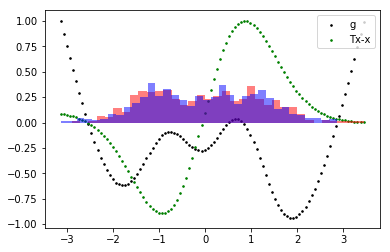

a= [-0.00562031  0.01834187  0.51265088  1.10362758  0.04226803] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00216651 -0.00032468 -0.00798439] b0z^2+b1z+b2
b gauss1= [ 0.00738775  1.59773817 -0.69949842] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.00628558 1.5953221  0.75556685] b6exp(-(b7(z+b8))^2/2)
Step n= 10


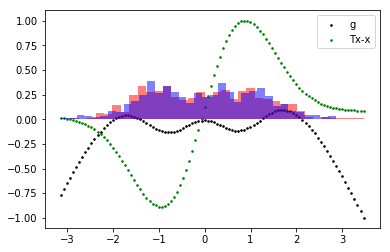

a= [0.00276423 0.0196096  0.49470381 1.09327953 0.04141815] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.01042193  0.00039372  0.0242484 ] b0z^2+b1z+b2
b gauss1= [-0.0247345   1.64110248 -0.69377485] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.0244557   1.64149027  0.73677094] b6exp(-(b7(z+b8))^2/2)
Step n= 11


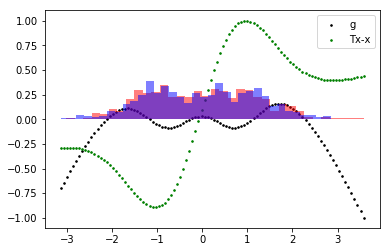

a= [0.03418082 0.01947243 0.43311535 1.0534292  0.04252928] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.01674954  0.00088572  0.04217428] b0z^2+b1z+b2
b gauss1= [-0.04182119  1.70168686 -0.6898831 ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.04016753  1.70533793  0.70954196] b6exp(-(b7(z+b8))^2/2)
Step n= 12


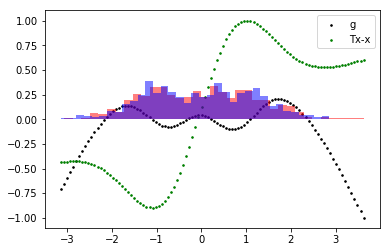

a= [0.04781644 0.01858977 0.40524983 1.03559934 0.04587428] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.01378706  0.00119563  0.03615419] b0z^2+b1z+b2
b gauss1= [-0.03706645  1.74189127 -0.68737822] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.03376652  1.74602422  0.69777442] b6exp(-(b7(z+b8))^2/2)
Step n= 13


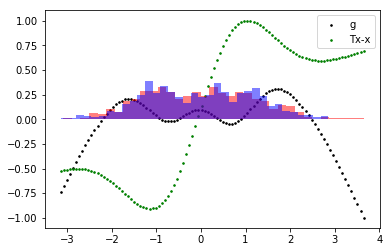

a= [0.05501266 0.01722167 0.39059311 1.02472182 0.04764272] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-0.00238488  0.0002907   0.00661615] b0z^2+b1z+b2
b gauss1= [-0.00634559  1.80165525 -0.66697585] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-0.00571089  1.80391198  0.67216397] b6exp(-(b7(z+b8))^2/2)
Step n= 14


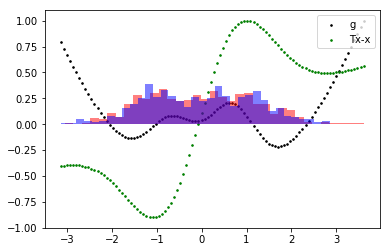

a= [0.04451644 0.01769645 0.41262893 1.0397573  0.04062233] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00518844 -0.00063924 -0.01269934] b0z^2+b1z+b2
b gauss1= [ 0.01530423  1.85529417 -0.63743856] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.01187796 1.85507886 0.64591693] b6exp(-(b7(z+b8))^2/2)
Step n= 15


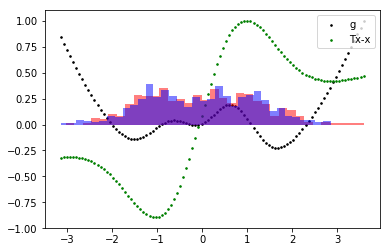

a= [0.03667225 0.01846761 0.42810312 1.0521829  0.03616162] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00570494 -0.00078595 -0.01352075] b0z^2+b1z+b2
b gauss1= [ 0.01609617  1.89034544 -0.62439047] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.0117158  1.88933674 0.63379006] b6exp(-(b7(z+b8))^2/2)
Step n= 16


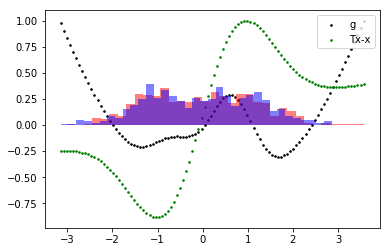

a= [0.03062097 0.01996369 0.4396276  1.06294513 0.03018634] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00170083 -0.00033985 -0.00412455] b0z^2+b1z+b2
b gauss1= [ 0.00546216  1.94492549 -0.60902689] b3exp(-(b4(z+b5))^2/2)
b gauss2= [0.00266879 1.94409088 0.61710244] b6exp(-(b7(z+b8))^2/2)
Step n= 17


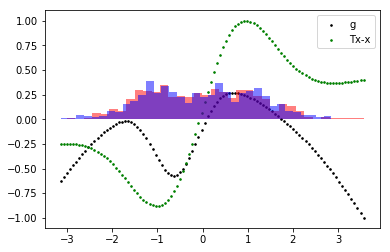

a= [0.03118325 0.0205833  0.43864306 1.06271207 0.02751485] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-2.52266687e-04 -1.52966060e-05  4.13487634e-04] b0z^2+b1z+b2
b gauss1= [ 3.62904332e-05  1.99321021e+00 -5.96380260e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-1.08941463e-03  1.99284299e+00  6.02402834e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 18


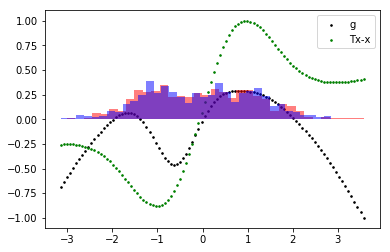

a= [0.03172826 0.02071559 0.43787574 1.06205931 0.02645867] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-2.64693466e-04  4.17039706e-06  5.46497703e-04] b0z^2+b1z+b2
b gauss1= [-1.31307028e-04  2.02326033e+00 -5.87870447e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-1.00570925e-03  2.02304332e+00  5.92994183e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 19


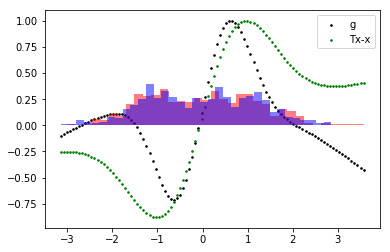

a= [0.03182955 0.02078008 0.43782845 1.06201774 0.02590233] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [-4.56531390e-05 -1.52515433e-05  1.25390922e-04] b0z^2+b1z+b2
b gauss1= [ 4.33687479e-04  2.04280632e+00 -5.81733802e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [-5.14638924e-04  2.04262869e+00  5.86475271e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 20


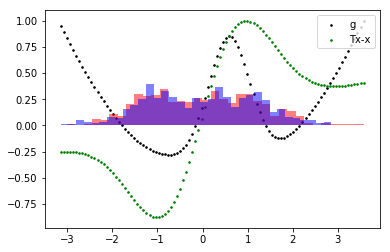

a= [0.03171825 0.0208479  0.43815988 1.06231155 0.02538936] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 2.39876980e-04 -4.45736873e-05 -4.65419618e-04] b0z^2+b1z+b2
b gauss1= [ 1.21717247e-03  2.06142405e+00 -5.75563572e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [8.64330235e-05 2.06125230e+00 5.80049903e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 21


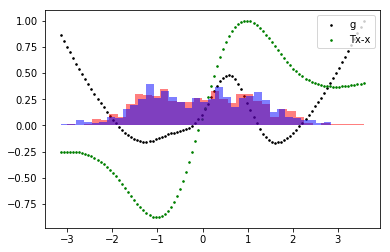

a= [0.03136262 0.02093996 0.43894444 1.06302433 0.02478248] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 5.80467909e-04 -7.98516387e-05 -1.19375926e-03] b0z^2+b1z+b2
b gauss1= [ 0.00216651  2.08199967 -0.56860587] b3exp(-(b4(z+b5))^2/2)
b gauss2= [7.86413916e-04 2.08181032e+00 5.72884823e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 22


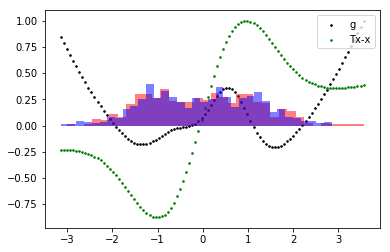

a= [0.02989765 0.02121321 0.44183695 1.06572516 0.02324811] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 0.00100665 -0.0001241  -0.00217059] b0z^2+b1z+b2
b gauss1= [ 0.00336204  2.12157257 -0.55610696] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.64173976e-03 2.12130910e+00 5.60061296e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 23


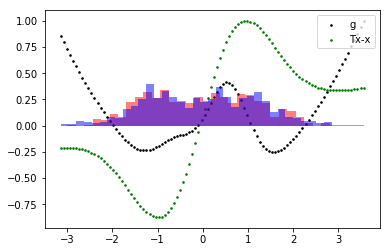

a= [0.02765127 0.02169537 0.44613861 1.07004789 0.02070109] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 6.50021967e-04 -8.34930403e-05 -1.45488770e-03] b0z^2+b1z+b2
b gauss1= [ 0.00232506  2.18229133 -0.540623  ] b3exp(-(b4(z+b5))^2/2)
b gauss2= [9.39498916e-04 2.18201173e+00 5.43857895e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 24


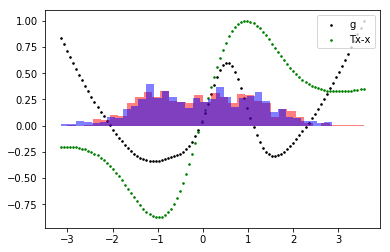

a= [0.02677048 0.02195645 0.44789179 1.07196643 0.01918743] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 2.12656246e-04 -2.55970129e-05 -5.01524869e-04] b0z^2+b1z+b2
b gauss1= [ 9.23321420e-04  2.23474467e+00 -5.29912971e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.98419807e-04 2.23453630e+00 5.32356965e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 25


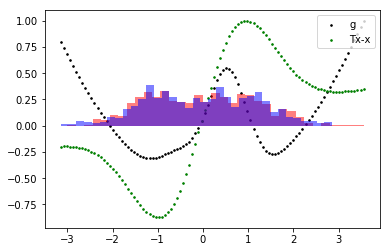

a= [0.02651164 0.02201699 0.44846878 1.07256329 0.01872894] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.42149174e-04 -1.34589037e-05 -3.29483889e-04] b0z^2+b1z+b2
b gauss1= [ 5.93132732e-04  2.26139369e+00 -5.24160869e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.55497937e-04 2.26121973e+00 5.26234837e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 26


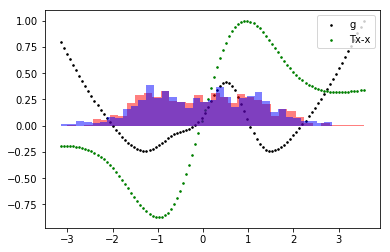

a= [0.0259812  0.0221031  0.44956321 1.07368744 0.01817548] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.35244424e-04 -1.22346492e-05 -2.94665392e-04] b0z^2+b1z+b2
b gauss1= [ 4.86204497e-04  2.30409217e+00 -5.16046812e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.11070957e-04 2.30396316e+00 5.17547481e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 27


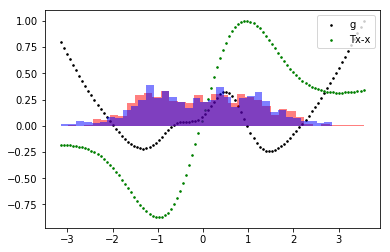

a= [0.02550989 0.02215144 0.45050782 1.07466638 0.01789282] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.15356470e-04 -1.00260738e-05 -2.47618244e-04] b0z^2+b1z+b2
b gauss1= [ 3.68169775e-04  2.34023803e+00 -5.09639474e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.21129401e-04 2.34014318e+00 5.10696908e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 28


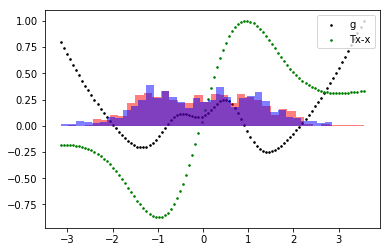

a= [0.02512241 0.02217365 0.45128254 1.07547314 0.01778785] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 9.32412073e-05 -7.97926368e-06 -1.98123122e-04] b0z^2+b1z+b2
b gauss1= [ 2.67248427e-04  2.37187067e+00 -5.04130155e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.06963649e-04 2.37180203e+00 5.04853741e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 29


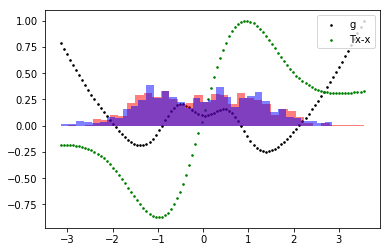

a= [0.02491977 0.02216761 0.45169271 1.07589622 0.01780874] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 9.81327972e-05 -7.83498518e-06 -2.04050861e-04] b0z^2+b1z+b2
b gauss1= [ 2.41478211e-04  2.38893217e+00 -5.00562892e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.52789597e-04 2.38887491e+00 5.01134787e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 30


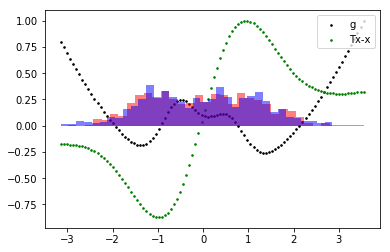

a= [0.02456    0.02216069 0.45240481 1.0766422  0.01790838] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 8.42813851e-05 -7.34762486e-06 -1.74876126e-04] b0z^2+b1z+b2
b gauss1= [ 1.91588928e-04  2.41837112e+00 -4.95219217e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.32381716e-04 2.41833090e+00 4.95572139e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 31


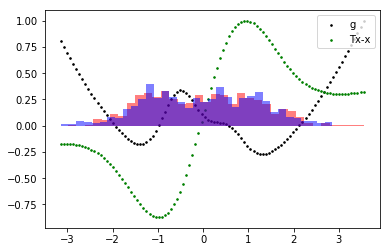

a= [0.02427997 0.02213876 0.45295908 1.07722889 0.01808274] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 6.48512637e-05 -5.69005383e-06 -1.33663351e-04] b0z^2+b1z+b2
b gauss1= [ 1.22049351e-04  2.44439254e+00 -4.90825603e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.02390639e-04 2.44436586e+00 4.91021386e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 32


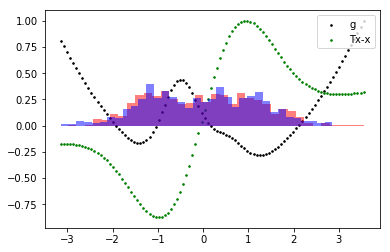

a= [0.02404971 0.02210608 0.45341544 1.0777143  0.01831171] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 5.29952552e-05 -4.77679137e-06 -1.07642011e-04] b0z^2+b1z+b2
b gauss1= [ 7.65312395e-05  2.46776500e+00 -4.86986316e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.86453582e-04 2.46774868e+00 4.87069449e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 33


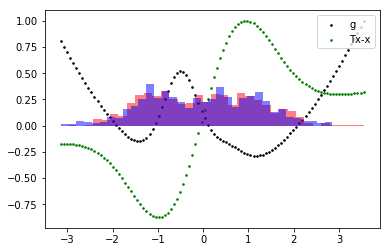

a= [0.02392622 0.02207689 0.45366267 1.07797616 0.01847299] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 5.71637683e-05 -4.84765577e-06 -1.13624634e-04] b0z^2+b1z+b2
b gauss1= [ 6.16124672e-05  2.48030154e+00 -4.84493177e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.19816043e-04 2.48029009e+00 4.84521759e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 34


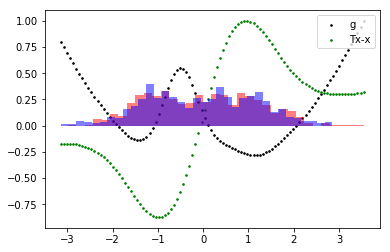

a= [0.02385529 0.02205615 0.45380689 1.07812921 0.01857435] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 6.61824386e-05 -5.28502245e-06 -1.29263102e-04] b0z^2+b1z+b2
b gauss1= [ 6.23147303e-05  2.48742816e+00 -4.82759966e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.63449166e-04 2.48741923e+00 4.82758940e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 35


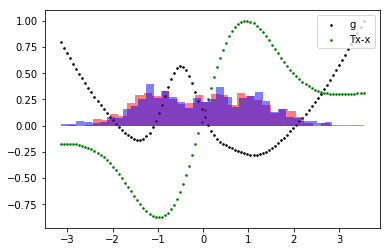

a= [0.02378781 0.02203471 0.45394386 1.07827503 0.01867351] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 7.83358509e-05 -6.04145111e-06 -1.51218692e-04] b0z^2+b1z+b2
b gauss1= [ 6.88637360e-05  2.49376058e+00 -4.81058510e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [3.16616692e-04 2.49375384e+00 4.81030913e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 36


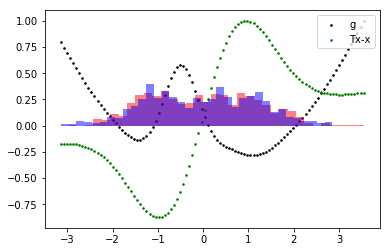

a= [0.02370677 0.02200877 0.45410546 1.07844797 0.01879366] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 9.25527475e-05 -7.14187517e-06 -1.77901296e-04] b0z^2+b1z+b2
b gauss1= [ 7.63454982e-05  2.50056705e+00 -4.79178677e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [3.78261823e-04 2.50056272e+00 4.79121082e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 37


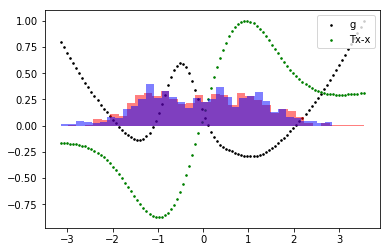

a= [0.02361322 0.02197935 0.45428846 1.07864521 0.01893542] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.04978194e-04 -8.33342677e-06 -2.02157444e-04] b0z^2+b1z+b2
b gauss1= [ 7.81844229e-05  2.50771596e+00 -4.77218373e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [4.36146586e-04 2.50771430e+00 4.77127798e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 38


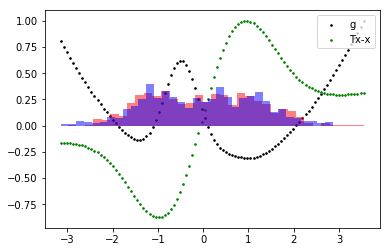

a= [0.02351147 0.02194759 0.45448488 1.07885844 0.01909738] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.12674576e-04 -9.34772885e-06 -2.18005167e-04] b0z^2+b1z+b2
b gauss1= [ 6.97041158e-05  2.51509822e+00 -4.75246623e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [4.80620464e-04 2.51509944e+00 4.75121314e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 39


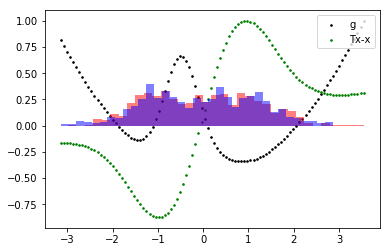

a= [0.02340725 0.02191439 0.45468461 1.07907687 0.01927682] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.14391311e-04 -1.00058394e-05 -2.22457756e-04] b0z^2+b1z+b2
b gauss1= [ 4.94824815e-05  2.52262350e+00 -4.73311171e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [5.06979013e-04 2.52262774e+00 4.73150951e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 40


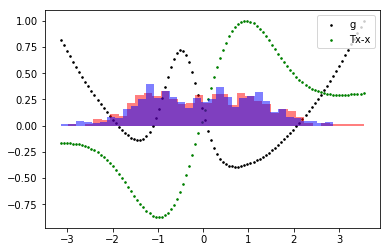

a= [0.02330609 0.02188039 0.45487815 1.07929009 0.01947038] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.10530026e-04 -1.02569525e-05 -2.15764138e-04] b0z^2+b1z+b2
b gauss1= [ 1.93410519e-05  2.53021719e+00 -4.71444062e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [5.15426593e-04 2.53022446e+00 4.71250279e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 41


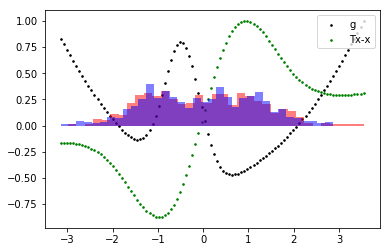

a= [0.02321204 0.02184593 0.45505849 1.07949034 0.01967463] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.02622637e-04 -1.01593456e-05 -2.00575065e-04] b0z^2+b1z+b2
b gauss1= [-1.66872944e-05  2.53781779e+00 -4.69665822e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [5.09606135e-04 2.53782802e+00 4.69440995e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 42


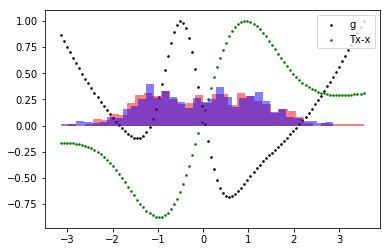

a= [0.02306201 0.02178252 0.45534587 1.0798168  0.02009583] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 7.74732945e-05 -9.31097328e-06 -1.50803552e-04] b0z^2+b1z+b2
b gauss1= [-7.85225869e-05  2.55251642e+00 -4.66884958e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [4.43079269e-04 2.55253162e+00 4.66614234e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 43


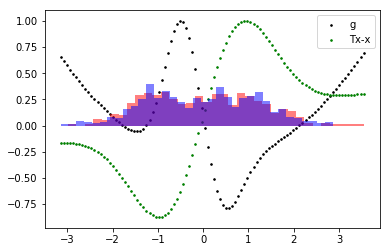

a= [0.02289757 0.02169344 0.45565981 1.080197   0.02076982] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 3.99570963e-05 -6.69636518e-06 -7.55113987e-05] b0z^2+b1z+b2
b gauss1= [-1.11769911e-04  2.57720105e+00 -4.63752639e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [2.92152098e-04 2.57722071e+00 4.63456641e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 44


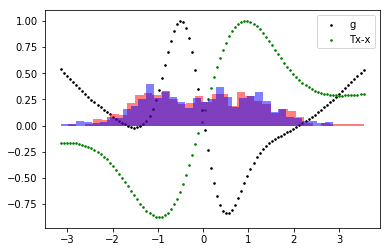

a= [0.02279263 0.02161753 0.45585897 1.08044896 0.02133298] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 2.23933516e-05 -4.48591212e-06 -4.02125642e-05] b0z^2+b1z+b2
b gauss1= [-1.02001389e-04  2.59922936e+00 -4.61711105e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.98318792e-04 2.59924966e+00 4.61429001e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 45


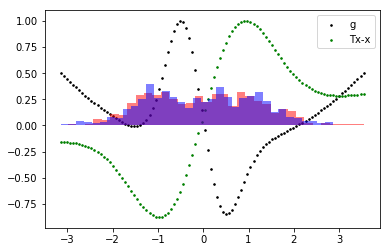

a= [0.02271686 0.02155588 0.45600119 1.08063035 0.02176858] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.60187462e-05 -3.29232344e-06 -2.78483026e-05] b0z^2+b1z+b2
b gauss1= [-8.29516712e-05  2.61687535e+00 -4.60298378e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.50725410e-04 2.61689463e+00 4.60044102e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 46


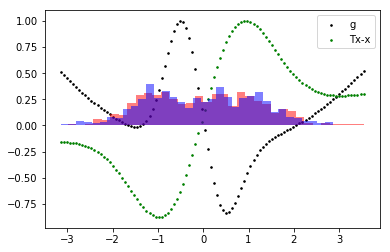

a= [0.02267938 0.02152315 0.45607256 1.08071802 0.02197776] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.59740248e-05 -2.91415109e-06 -2.75406059e-05] b0z^2+b1z+b2
b gauss1= [-7.82767196e-05  2.62513516e+00 -4.59490009e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.46794695e-04 2.62515392e+00 4.59248538e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 47


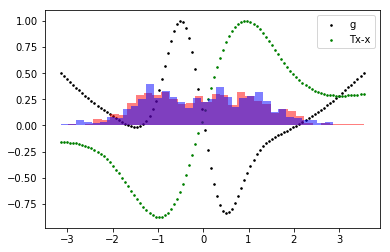

a= [0.02261658 0.02147013 0.45618924 1.08086559 0.0223297 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 1.30824465e-05 -2.57748279e-06 -2.25425538e-05] b0z^2+b1z+b2
b gauss1= [-6.72948919e-05  2.63860961e+00 -4.58346920e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.23166310e-04 2.63862698e+00 4.58131863e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 48


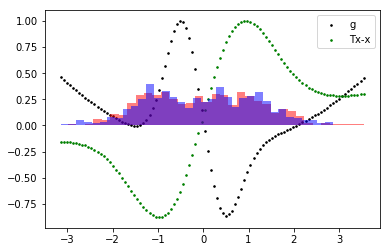

a= [0.02256854 0.02142487 0.45627822 1.0809803  0.0226287 ] (1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)
b poly= [ 9.96426752e-06 -2.12462956e-06 -1.68736724e-05] b0z^2+b1z+b2
b gauss1= [-6.04718242e-05  2.64973099e+00 -4.57434031e-01] b3exp(-(b4(z+b5))^2/2)
b gauss2= [1.02001510e-04 2.64974670e+00 4.57245501e-01] b6exp(-(b7(z+b8))^2/2)
Step n= 49
done


In [16]:
#local minimax algorithm, rejction using G, update eta with D
Niter = 50
eps = 1e-6
eta0 = 0.05
eta = eta0
etaC = 2.0


#setting up initial b, and minvar,D
vx = np.var(x)
vy = np.var(y)
mx = np.mean(x)
my = np.mean(y)
vxy = np.var(np.concatenate([x,y]))
D = np.sqrt(vxy)
mxy = np.mean(np.concatenate([x,y]))
#initial a
a0 = np.zeros(da)
a0[3] = 1/D
#initial b
b00 = np.array([1.0/vy -1.0/vx,mx/vx - my/vy,0.5*(my**2/vy-mx**2/vx)])
b01 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
b01[0] = 0
b01[1] = 1/D
b02 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
b02[0] = 0
b02[1] =1/D
b0 = np.concatenate([b00,b01,b02])
z = np.concatenate([a0,b0],axis=0)
I = np.eye(da+db)
minvar0 = 1e-12
x0 = np.zeros((Nx,2))
x0[:,0] = x
y0 = np.zeros((Ny,2))
y0[:,0] = y
dsq = spatial.distance.cdist(x0,y0,'sqeuclidean')
minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
delta0 = np.sqrt(minvar)
dsq2 = spatial.distance.cdist(x0,x0,'sqeuclidean')
dsq2 += 100*np.eye(Nx)
minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
deltainf =  np.sqrt(minvar2)
deltainf = delta0/5 #debug

delta = delta0
#Initial gradient
Gn,Hn = GH(a0,b0,delta,D)
Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])

a3xa4 = z[3]*(x + z[4])
a3xa42 = a3xa4**2
expo = np.exp(-0.5*a3xa42)
Tx1 = z[2]*expo*z[3]*a3xa4
Tx = (1+z[0])*x+z[1] + Tx1

Dn = abs(Mn + mn)
###debug####
listG = []
listD = []
listS = []
lists = []
listeta = []
Tx = x#debug
gtot = 0#debug
############

for n in range(Niter):
    Gnold = Gn
    Dnold = Dn
    
    delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
    ####Debug########
    listG.append(la.norm(Gn,2))
    listD.append(Dn)
    listS.append(Mn)
    lists.append(mn)
    listeta.append(eta)
    #PLOTS FOR DEBUG
    Txold = Tx
    gtotold = gtot
    bins = 35
    a3xa4 = z[3]*(x + z[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = z[2]*expo*z[3]*a3xa4
    Tx = (1+z[0])*x+z[1] + Tx1
    plt.hist(Tx,density=True, bins=bins, color='red', alpha = 0.5);
    plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);
    grid = np.linspace(min(np.amin(Tx),np.amin(y)),max(np.amax(Tx),np.amax(y)),num=100)
    bt = z[da:]
    g1 = bt[3]*np.exp(-0.5*(bt[4]*(grid + bt[5]))**2)
    g2 = bt[6]*np.exp(-0.5*(bt[7]*(grid + bt[8]))**2)
    g3 = 0.5*bt[0]*grid**2+bt[1]*grid+bt[2]
    gtot = g1+g2+g3
#     plt.scatter(grid,g1/np.max(np.abs(g1)),color='green')
#     plt.scatter(grid,g2/np.max(np.abs(g2)),color='blue')
#     plt.scatter(grid,g3/np.max(np.abs(g3)),color='purple')
    plt.scatter(grid,gtot/np.max(np.abs(gtot)),color='black', s=2.5, label='g')
#     plt.scatter(grid,(gtot-gtotold)/np.max(np.abs(gtot-gtotold)),color='blue', s=2.5, label='dg')
#     plt.draw()
#     plt.pause(1e-5)
    at = z[:da]
    a3xa4 = at[3]*(grid + at[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = at[2]*expo*at[3]*a3xa4
    Uxg = at[0]*grid+at[1] + Tx1
    plt.scatter(grid,Uxg/np.max(Uxg),color='green', s=2.5, label='Tx-x')
#     plt.scatter(Txold,(Tx-Txold)/np.max(np.abs(Tx-Txold)),color='red', s=2.5, label='dTx')
    plt.legend(loc='upper right')
    plt.draw()
    plt.pause(1e-5)
#      plt.scatter(grid,Uxg-Uxgold,color='red')
#     plt.draw()
#     plt.pause(1e-5)
    print('a=',z[:da], '(1+a0)x+a1+a2*a3^2*(x+a4)*exp(-(a3(x+a4))^2/2)')
    print('b poly=',z[da:da+3], 'b0z^2+b1z+b2')
    print('b gauss1=', z[da+3:da+6], 'b3exp(-(b4(z+b5))^2/2)')
    print('b gauss2=', z[da+6:], 'b6exp(-(b7(z+b8))^2/2)')
    print('Step n=',n)
    ##########################################     
    
    if la.norm(Gn,2)<eps:
        break
    #reject moves if bad direction
    baddir = True
    eta = 2.0*eta
    while(baddir and eta>eta0):
        eta = eta/2.0
        dz = la.solve((1.0/eta)*I+Hn,Gn)
        baddir = dz.dot(Gn)<0.0
    z = z - dz
    
    Gn,Hn = GH(z[:da],z[da:],delta,D)
    Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
    Mn = Gx.T.dot(la.lstsq(Hxx,Gx)[0])
    mn = Gy.T.dot(la.lstsq(Hyy,Gy)[0])
    Dn = abs(Mn + mn)
    #etamin = eta0/(la.norm(Gn,2)+1)#debug
    if Dn<=Dnold:
        eta = min((etaC+0.1)*eta,25.0/(1+la.norm(Gn,2)))#debug
    else:
        eta = max(eta/etaC, 5.0/(1+la.norm(Gn,2)))
print('done')

In [16]:
deltainf

0.10644179538884102

In [80]:
D

1.1542771796174958

In [18]:
z

array([ 2.25481110e-01, -1.91427675e-02,  9.40288674e-02,  2.54662563e+00,
       -1.83981432e-02, -3.13151072e-02,  3.36869370e-03,  1.70606061e-02,
        2.53855603e-01,  2.39806436e+00, -2.60843859e-03, -2.56477010e-01,
        2.71632046e+00,  1.26077575e-04])

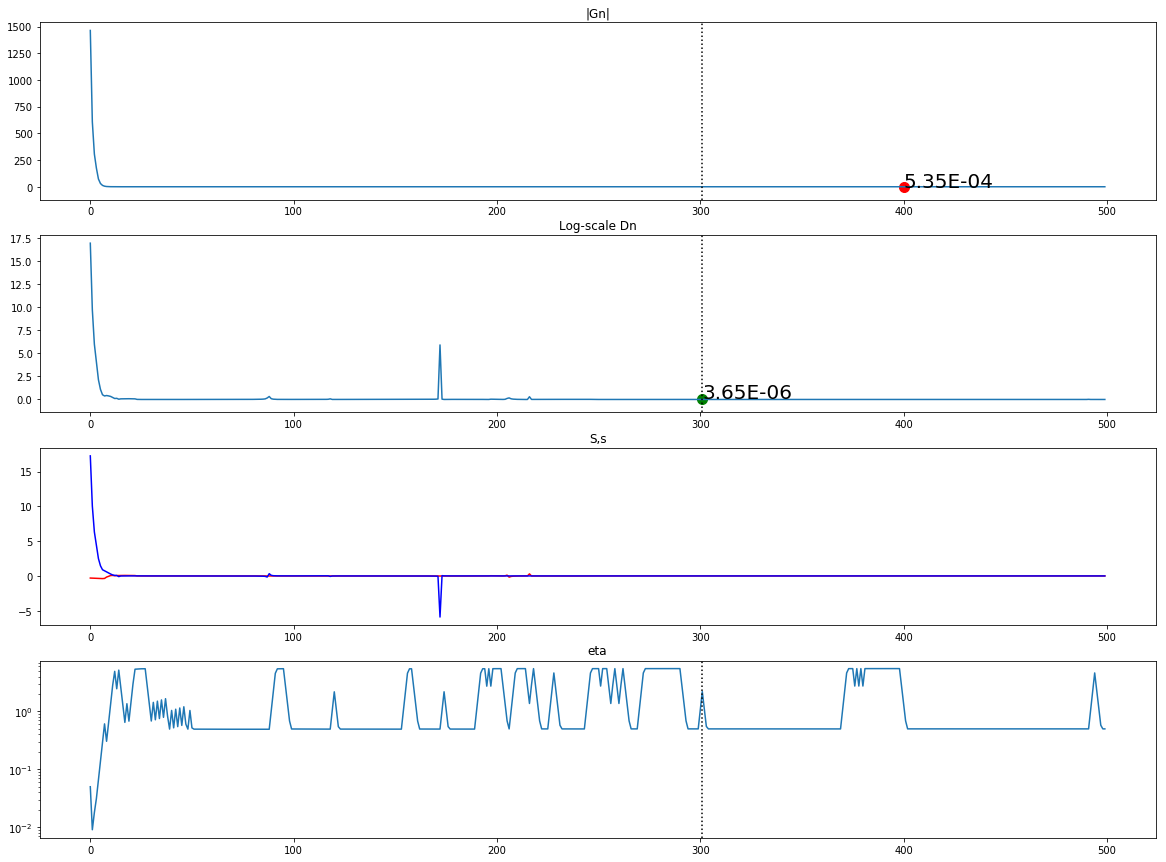

In [8]:
from decimal import Decimal
#####DEBUG#####
#find minimal Gn, Dn
minG = np.min(listG)
iminG = np.argmin(listG)
minD = np.min(np.absolute(listD))
iminD = np.argmin(np.absolute(listD))

fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(listG)
ax1.scatter(iminG,minG, c = 'r', s = 100)
decG = '%.2E' % Decimal(minG)
ax1.annotate(decG, (iminG,minG+0.1), fontsize=20)
ax1.set_title('|Gn|')
ax1.axvline(iminD, c = 'black', ls = 'dotted')

ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(listD)
ax2.scatter(iminD,minD, c = 'g', s = 100)
decD = '%.2E' % Decimal(minD)
ax2.annotate(decD, (iminD,minD+0.1), fontsize=20)
ax2.axvline(iminD, c = 'black', ls = 'dotted')
ax2.set_title('Log-scale Dn')

ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(listS, c = 'r')
ax3.plot(lists, c = 'b')
ax3.set_title('S,s');

ax4 = fig.add_subplot(4, 1, 4)
ax4.semilogy(listeta)
ax4.axvline(iminD, c = 'black', ls = 'dotted')
ax4.set_title('eta');
###############

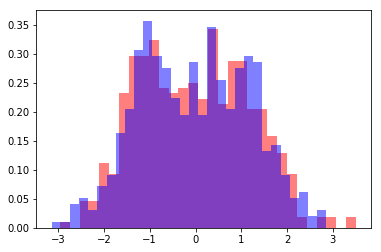

In [12]:
a,b = z[:da],z[da:]
Txa = (1+a[0])*x + a[1] + a[2]*a[3]**2 * (x+a[4]) * np.exp(-0.5*(a[3]*(x+a[4]))**2)
#plots
bins = 30
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
# plt.show()
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);
# plt.show()

In [21]:
print(np.var(y))
print(np.var(Txa))

1.5809834703675418
1.5267218522284383


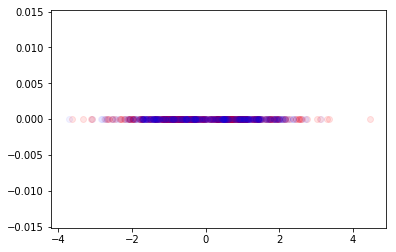

In [22]:
plt.scatter(Txa,np.zeros_like(Txa),color='red',alpha = 0.1);
plt.scatter(y,np.zeros_like(y), color='blue',alpha = 0.05);
# plt.scatter(x,np.zeros_like(x), color='green',alpha = 0.3);

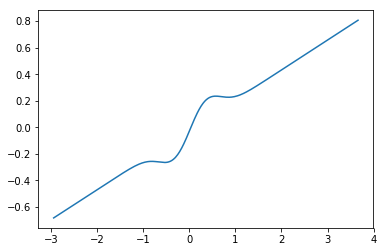

In [23]:
index = np.argsort(x)
u = Txa-x
plt.plot(x[index],u[index]);

## Packaged Algorithm

In [49]:
def local_ot(x,y,Niter=200):#Updates eta using Dn instead of Gn
    try:
        Nx,d = x.shape
    except ValueError:
        Nx = len(x)
        d = 1
    Ny = len(y)
    da = 2+2*d+d**2
    db = 3*d+6

    #Precomputed data, (twisted) gradient and Hessian
    xh = np.concatenate([x.reshape(Nx,d),np.ones((Nx,d))],axis=1)

    gammaA = 2*1e-1 #alpha regularization parameter 
    gammaB = 2*1e-1 #beta regularization parameter

    def GH(a,b,eps,D):

        #precomputations
        Tx0 = (1+a[0])*x+a[1] 
        xa4 = x + a[4]
        a3xa4 = a[3]*xa4
        a3xa42 = a3xa4**2
        expo = np.exp(-0.5*a3xa42)
        Tx1 = a[2]*a[3]*a3xa4*expo
        Tx = Tx0 + Tx1

        g0y = 0.5*b[0]*y**2 + b[1]*y + b[2]
        argexpy1 =  (b[4]*(y + b[5]))**2
        expoy1 = np.exp(-0.5*argexpy1)
        argexpy2 =  (b[7]*(y + b[8]))**2
        expoy2 = np.exp(-0.5*argexpy2)
        g1y = b[3]*expoy1
        g2y = b[6]*expoy2
        gy = g0y + g1y + g2y
        g0Tx = 0.5*b[0]*Tx**2 + b[1]*Tx + b[2]
        argexpT1 =  (b[4]*(Tx + b[5]))**2
        expoT1 = np.exp(-0.5*argexpT1)
        argexpT2 =  (b[7]*(Tx + b[8]))**2
        expoT2 = np.exp(-0.5*argexpT2)
        g1Tx = b[3]*expoT1
        g2Tx = b[6]*expoT2
        gTx = g0Tx + g1Tx + g2Tx   

        g0pTx = b[0]*Tx + b[1]
        g1pTx = -b[4]**2 * (Tx+b[5])*g1Tx
        g2pTx = -b[7]**2 * (Tx+b[8])*g2Tx
        gpTx = g0pTx + g1pTx + g2pTx

        daT = np.zeros((Nx,da))
        daT[:,0] = x
        daT[:,1] = np.ones(Nx)
        daT[:,2] = expo*a[3]*a3xa4
        daT[:,3] = a[2] * a3xa4 * expo * (2.0 - a3xa42)
        daT[:,4] = a[2]*a[3]**2 * expo * (1.0 - a3xa42)

        #gradient w.r.t. a
        penalty_a = np.array([a[0],a[1]/D**2,a[2],eps**2*a[3]*np.exp((eps*a[3])**2)-1.0/(D**2 * a[3]**3),1*a[4]/(10*D**2)]) 
        daL = (1.0/Nx) * np.einsum('i,ik->k',gpTx,daT) + gammaA*(1+(1/Nx)*la.norm(gpTx))*penalty_a

        expgy = np.exp(gy)
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = 0.5*y**2
        dbgT[:,0] = 0.5*Tx**2
        dbgy[:,1] = y
        dbgT[:,1] = Tx
        dbgy[:,2] = np.ones(Ny)
        dbgT[:,2] = np.ones(Nx) 
        dbgy[:,3] = expoy1
        dbgT[:,3] = expoT1
        dbgy[:,4] = -b[4]*(y+b[5])**2 * g1y
        dbgT[:,4] = -b[4]*(Tx+b[5])**2 * g1Tx
        dbgy[:,5] = -b[4]**2 * (y+b[5])*g1y
        dbgT[:,5] = -b[4]**2 * (Tx+b[5])*g1Tx
        dbgy[:,6] = expoy2
        dbgT[:,6] = expoT2
        dbgy[:,7] = -b[7]*(y+b[8])**2 * g2y
        dbgT[:,7] = -b[7]*(Tx+b[8])**2 * g2Tx
        dbgy[:,8] = -b[7]**2 * (y+b[8])*g2y
        dbgT[:,8] = -b[7]**2 * (Tx+b[8])*g2Tx
        #gradient w.r.t. b
        penalty_b = np.array([0,0,0,0,eps**2*b[4]*np.exp((eps*b[4])**2)-1*1/(D**2 *b[4]**3),1*b[5]/(10*D**2),0,eps**2*b[7]*np.exp((eps*b[7])**2)-1*1/(D**2 *b[7]**3),1*b[8]/(10*D**2)])
        dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

        #twisted gradient
        G = np.concatenate([daL,-dbL],axis=0)

        g0ppTx = b[0]*np.ones(Nx)
        g1ppTx = -b[4]**2 *g1Tx*(1.0-b[4]**2 * (Tx+b[5]))
        g2ppTx = -b[7]**2 *g2Tx*(1.0-b[7]**2 * (Tx+b[8]))
        gppTx = g0ppTx+g1ppTx+g2ppTx

        daaT = np.zeros((Nx,da,da))
        daaT[:,2,3] = a3xa4 * expo * (2.0 - a3xa42)
        daaT[:,2,4] = a[3]**2 * expo * (1.0 - a3xa42)
        daaT[:,3,3] = a[2] * xa4 * expo * (2.0-3*a3xa42-a3xa42*(2.0-a3xa42))
        daaT[:,3,4] = a[2]*a[3] * expo * (2.0 + a3xa42*(a3xa42-5.0))
        daaT[:,4,4] = -a[2]*a[3]**4 *xa4 * expo * (3.0 + a3xa42)
        #Hessian w.r.t. aa
        penaltyH_a = np.eye(da)
        penaltyH_a[1,1] = 1.0/D**2
        penaltyH_a[4,4] = 1*1.0/(10*D**2)
        penaltyH_a[3,3] = eps**2 * np.exp((a[3]*eps)**2)*(1.0+2.0*a[3]*eps**2) + 3/(D**2 * a[3]**4)
        daaL = (1.0/Nx)*(np.einsum('i,ikl->kl',gpTx,daaT) + np.einsum('i,ik,il->kl',gppTx,daT,daT)) + gammaA*(1+(1/Nx)*la.norm(gpTx))*penaltyH_a

        dbgpTx = np.zeros((Nx,db))
        dbgpTx[:,0] = Tx
        dbgpTx[:,1] = np.ones(Nx)
        dbgpTx[:,3] = -b[4]**2 * (Tx+b[5]) * expoT1
        dbgpTx[:,4] = b[4]*b[3]*(Tx+b[5])*expoT1*(-2.0+b[4]**2 * (Tx+b[5])**2)
        dbgpTx[:,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
        dbgpTx[:,6] = -b[7]**2 * (Tx+b[8]) * expoT2
        dbgpTx[:,7] = b[7]*b[6]*(Tx+b[8])*expoT2*(-2.0+b[7]**2 * (Tx+b[8])**2)
        dbgpTx[:,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)

        #Hessian w.r.t. ab
        dabL = (1.0/Nx)*np.einsum('in,ik->kn',dbgpTx,daT)

        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        dbbgy[:,3,4] = -b[4]*(y+b[5])**2 * expoy1
        dbbgT[:,3,4] = -b[4]*(Tx+b[5])**2 * expoT1
        dbbgy[:,3,5] = -b[4]**2 * (y+b[5])* expoy1
        dbbgT[:,3,5] = -b[4]**2 * (Tx+b[5])* expoT1
        dbbgy[:,4,4] = b[3]*(y+b[5])**2 * expoy1 * (-1.0+argexpy1)
        dbbgT[:,4,4] = b[3]*(Tx+b[5])**2 * expoT1 * (-1.0+argexpT1)
        dbbgy[:,4,5] = b[3]*b[4]*(y+b[5])*expoy1*(-2.0+b[4]*(y+b[5]))
        dbbgT[:,4,5] = b[3]*b[4]*(Tx+b[5])*expoT1*(-2.0+b[4]*(Tx+b[5]))
        dbbgy[:,5,5] = b[3]*b[4]**2 * expoy1*(-1.0+argexpy1)
        dbbgT[:,5,5] = b[3]*b[4]**2 * expoT1*(-1.0+argexpT1)
        dbbgy[:,6,7] = -b[7]*(y+b[8])**2 * expoy2
        dbbgT[:,6,7] = -b[7]*(Tx+b[8])**2 * expoT2
        dbbgy[:,6,8] = -b[7]**2 * (y+b[8])* expoy2
        dbbgT[:,6,8] = -b[7]**2 * (Tx+b[8])* expoT2
        dbbgy[:,7,7] = b[6]*(y+b[8])**2 * expoy2 * (-1.0+argexpy2)
        dbbgT[:,7,7] = b[6]*(Tx+b[8])**2 * expoT2 * (-1.0+argexpT2)
        dbbgy[:,7,8] = b[6]*b[7]*(y+b[8])*expoy2*(-2.0+b[7]*(y+b[8]))
        dbbgT[:,7,8] = b[6]*b[7]*(Tx+b[8])*expoT2*(-2.0+b[7]*(Tx+b[8]))
        dbbgy[:,8,8] = b[6]*b[7]**2 * expoy2*(-1.0+argexpy2)
        dbbgT[:,8,8] = b[6]*b[7]**2 * expoT2*(-1.0+argexpT2)
        #symmetrize tensors
        dbbgy = dbbgy + np.transpose(dbbgy,(0,2,1))
        dbbgy[:,np.arange(db),np.arange(db)] *= 0.5
        dbbgT = dbbgT + np.transpose(dbbgT,(0,2,1))
        dbbgT[:,np.arange(db),np.arange(db)] *= 0.5

        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        #Hessian w.r.t. bb
        penaltyH_b = np.zeros((db,db))
        penaltyH_b[5,5] = 1*1.0/(10*D**2)
        penaltyH_b[8,8] = 1*1.0/(10*D**2)
        penaltyH_b[4,4] = eps**2 * np.exp((b[4]*eps)**2)*(1.0+2.0*b[4]*eps**2) + 1*3/(D**2 * b[4]**4)
        penaltyH_b[7,7] = eps**2 * np.exp((b[7]*eps)**2)*(1.0+2.0*b[7]*eps**2) + 1*3/(D**2 * b[7]**4)
        dbbL = (1.0/Nx)*np.sum(dbbgT,axis=0) - (1.0/Ny)*np.einsum('jnm,j->nm',(dbbgy+dbgdbg),expgy) - gammaB*penaltyH_b

        #Twisted Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = -dabL.T
        H[da:,da:] = -dbbL
        return(G,H)
     
    #local minimax algorithm, rejction using G, update eta with D
    #Niter = 200
    eps = 1e-6
    eta0 = 0.5
    eta = eta0
    etaC = 2.0


    #setting up initial b, and minvar,D
    vx = np.var(x)
    vy = np.var(y)
    mx = np.mean(x)
    my = np.mean(y)
    vxy = np.var(np.concatenate([x,y]))
    D = np.sqrt(vxy)
    mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[3] = 1/D
    #initial b
    b00 = np.array([1.0/vy -1.0/vx,mx/vx - my/vy,0.5*(my**2/vy-mx**2/vx)])
    b01 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
    b01[0] = 0
    b01[1] = 1/D
    b02 = 1*np.random.uniform(low=-1.0,high=1.0,size=d+2)
    b02[0] = 0
    b02[1] =1/D
    b0 = np.concatenate([b00,b01,b02])
    z = np.concatenate([a0,b0],axis=0)
    I = np.eye(da+db)
    minvar0 = 1e-12
    x0 = np.zeros((Nx,2))
    x0[:,0] = x
    y0 = np.zeros((Ny,2))
    y0[:,0] = y
    dsq = spatial.distance.cdist(x0,y0,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x0,x0,'sqeuclidean')
    dsq2 += 100*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
    deltainf = delta0/5 #debug

    delta = delta0
    #Initial gradient
    Gn,Hn = GH(a0,b0,delta,D)
    Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
    Mn = Gx.T.dot(la.lstsq(Hxx,Gx,rcond=None)[0])
    mn = Gy.T.dot(la.lstsq(Hyy,Gy,rcond=None)[0])

    a3xa4 = z[3]*(x + z[4])
    a3xa42 = a3xa4**2
    expo = np.exp(-0.5*a3xa42)
    Tx1 = z[2]*expo*z[3]*a3xa4
    Tx = (1+z[0])*x+z[1] + Tx1

    Dn = abs(Mn + mn)
    
    for n in range(Niter):
        delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf        
        if la.norm(Gn,2)<eps:
            break
        #reject moves if bad direction
        baddir = True
        eta = 2.0*eta
        while(baddir and eta>eta0):
            eta = eta/2.0
            dz = la.solve((1.0/eta)*I+Hn,Gn)
            baddir = dz.dot(Gn)<0.0
        z = z - dz

        Gn,Hn = GH(z[:da],z[da:],delta,D)
        Hxx = Hn[:da,:da]; Hyy = Hn[da:,da:]; Gx = Gn[:da]; Gy = Gn[da:]
        Mn = Gx.T.dot(la.lstsq(Hxx,Gx,rcond=None)[0])
        mn = Gy.T.dot(la.lstsq(Hyy,Gy,rcond=None)[0])
        Dn = abs(Mn + mn)
        etamin = eta0/(la.norm(Gn,2)+1)#debug
        if Dn<=Dnold:
            eta = min((etaC+0.1)*eta,2)
        else:
            eta = max(etamin,eta/etaC)
    a,b = z[:da],z[da:]
    Txa = (1+a[0])*x + a[1] + a[2]*a[3]**2 * (x+a[4]) * np.exp(-0.5*(a[3]*(x+a[4]))**2)
    return(Txa,a,b)

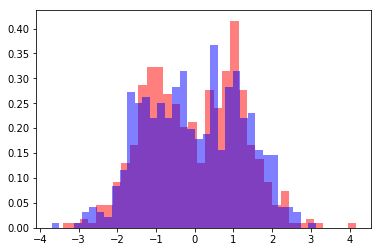

In [58]:
Txa,a,b = local_ot(x,y,Niter=40)
#plots
bins = 35
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

# Global Algorithm

## Open Version

In [59]:
def idx_choice(x,y):
    Nx = len(x)
    Ny = len(y)
    #assignement for x:
    idxx = np.zeros(Nx)
    q = int(Nx/Ny)
    r = Nx % Ny
    for i in range(q):
        idxx[i*Ny:(i+1)*Ny] = np.random.choice(np.arange(Ny),Ny,replace=False)
    idxx[-r:] = np.random.choice(np.arange(Ny),r,replace=False)
    #assignement for y:
    idxy = np.zeros(Ny)
    q = int(Ny/Nx)
    r = Ny % Nx
    for i in range(q):
        idxy[i*Nx:(i+1)*Nx] = np.random.choice(np.arange(Nx),Nx,replace=False)
    idxy[-r:] = np.random.choice(np.arange(Nx),r,replace=False)
    return(y[idxx.astype(int)],x[idxy.astype(int)])   

0.0


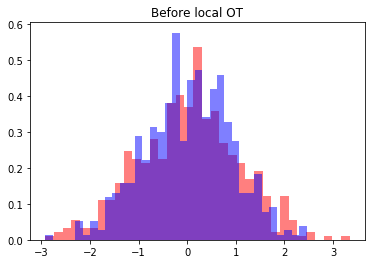

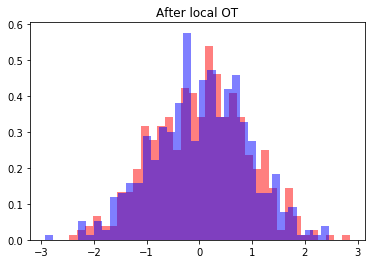

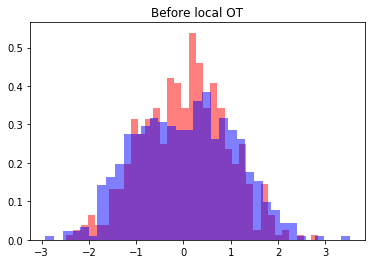

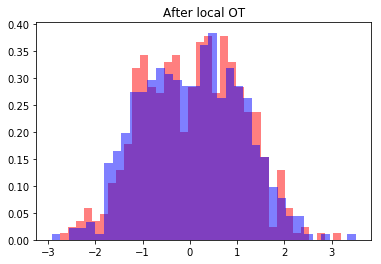

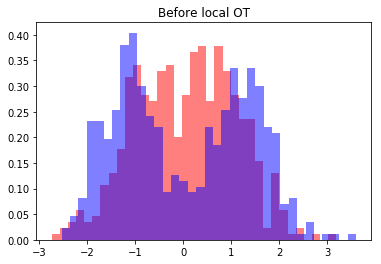

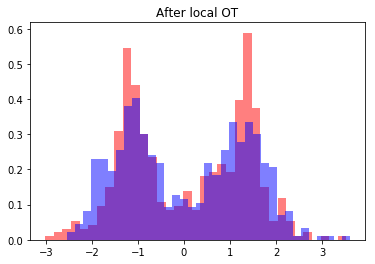

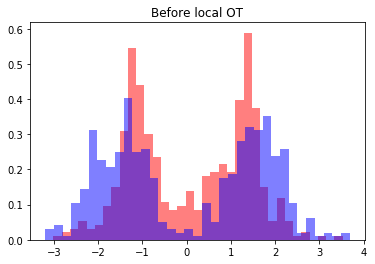

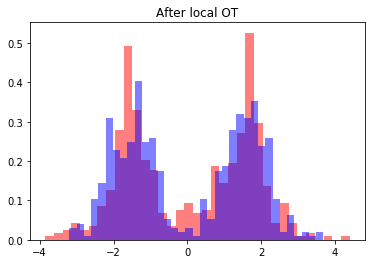

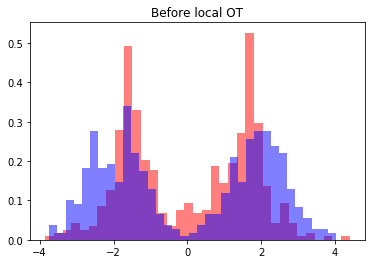

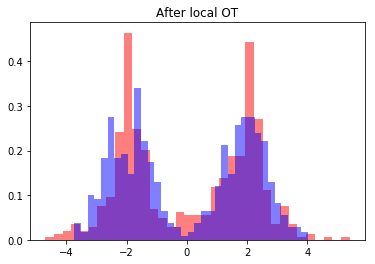

1.0


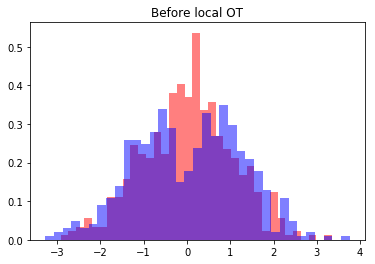

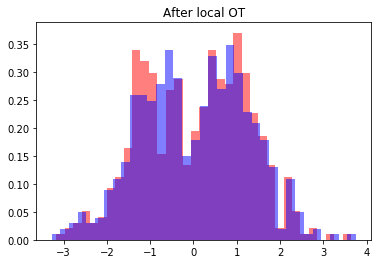

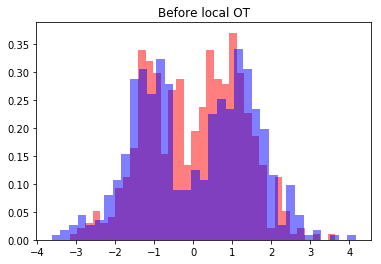

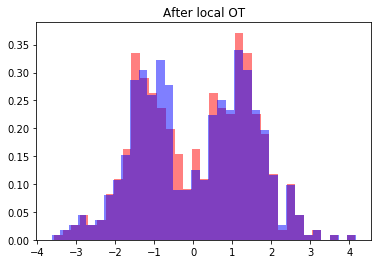

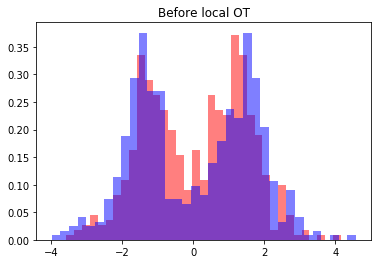

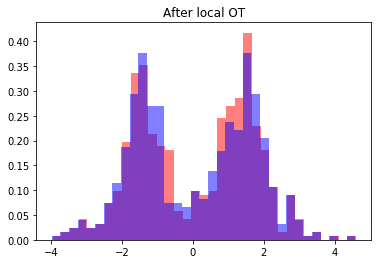

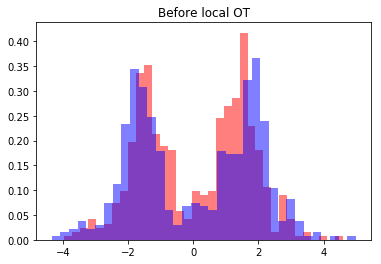

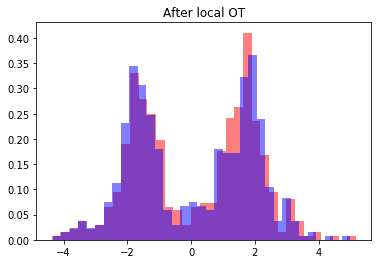

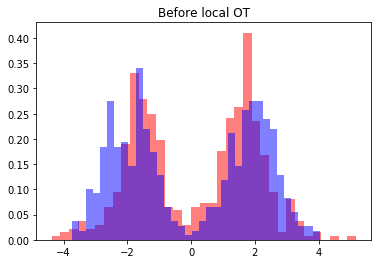

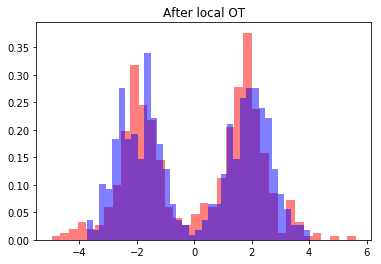

done


In [65]:
K = 5
Maxiter = 100
tol = 1e-2

Nx = len(x)
Ny = len(y) 
a_maps = K*[0]
b_maps = K*[0]

# #Initialize intermediary distributions with random selections for x
# x_K = np.array([y[np.random.randint(0,Ny)] for i in range(Nx)])
# mu = []
# mu.append(x)
# for k in range(1,K):
#     z = (1-k/K)*x+(k/K)*x_K
#     mu.append(z)
# mu.append(y)

#Initialize intermediary distributions both from x and y
x_K, y_0 = idx_choice(x,y)
mu = []
mu.append(x)
for k in range(1,K):
    zx = np.random.choice((1-k/K)*x+(k/K)*x_K,int(Nx*(1-k/K)),replace=False)
    zy = np.random.choice((1-k/K)*y_0+(k/K)*y,int(Ny*k/K),replace=False)
    z = np.concatenate([zx,zy])
    mu.append(z)
mu.append(y)
    

for niter in range(Maxiter):
    print(niter/Maxiter * 100)#debug
    x_Kold=x_K
    #solve local OT's
    z = x
    for k in range(1,K+1):
#         #plot before transport
        bins = 35
        plt.hist(z,density=True, bins=bins, color='red', alpha = 0.5);
        plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);
        plt.title('Before local OT')
        plt.draw()
        plt.show()
        
        #solve local transport problem
        Tloc,a,b = local_ot(z,mu[k],Niter=40)
        
        #plot after transport
        bins = 35
        plt.hist(Tloc,density=True, bins=bins, color='red', alpha = 0.5);
        plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);
        plt.title('After local OT')
        plt.draw()
        plt.show()
        
        a_maps[k-1] = a
        b_maps[k-1] = b
        z = Tloc
    x_K = z
    if (1/Nx)*np.linalg.norm(x_K-x_Kold,2)<tol:
        break
    #update intermediate distributions
    for k in range(1,K):
        mu[k] = (1-k/K)*x+(k/K)*x_K

print('done')

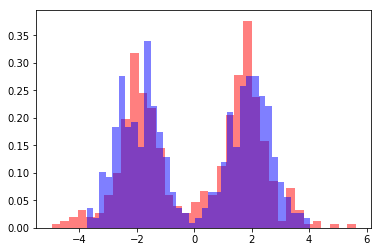

In [68]:
#plots
bins = 35
plt.hist(x_K,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

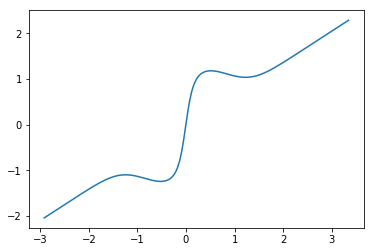

In [71]:
index = np.argsort(x)
u = x_K-x
plt.plot(x[index],u[index]);

## Packaged version

In [ ]:
def sot(x,y,K=10,tol=1e-1,Maxiter=50):
    Nx = len(x)
    Ny = len(y) 
    c_maps = K*[0]
    a_maps = K*[0]
    b_maps = K*[0]
    #Initialize intermediary distributions
    x_K = np.array([y[np.random.randint(0,Ny)] for i in range(Nx)])
    mu = []
    mu.append(x)
    for k in range(1,K):
        z = (1-k/K)*x+(k/K)*x_K
        mu.append(z)
    mu.append(y)
    
#     #plots
#     plt.figure(figsize=(20, 4))
#     for i in range(K+1):
#         plt.subplot(1, K+1, i+1)
#         plt.scatter(mu[i],np.zeros_like(mu[i]))
#     plt.draw()
#     plt.show()
    
    for niter in range(Maxiter):
        print(niter/Maxiter * 100)#debug
        x_Kold=x_K
        #solve local OT's
        z = x
        for k in range(1,K+1):
            Tloc,c,a,b = local_ot2(z,mu[k])
            c_maps[k-1] = c
            a_maps[k-1] = a
            b_maps[k-1] = b
            z = Tloc
        x_K = z
        if (1/Nx)*np.linalg.norm(x_K-x_Kold,2)<tol:
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = (1-k/K)*x+(k/K)*x_K
        
#         #plots
#         plt.figure(figsize=(20, 4))
#         for i in range(K+1):
#             plt.subplot(1, K+1, i+1)
#             plt.scatter(mu[i],np.zeros_like(mu[i]))
#         plt.draw()
#         plt.show()
        
    return(x_K, c_maps, a_maps, b_maps)

In [ ]:
Txa,c,a,b = sot(x,y)

In [ ]:
#plots
bins = 35
plt.hist(Txa,density=True, bins=bins, color='red', alpha = 0.5);
plt.hist(y,density=True, bins=bins, color='blue', alpha = 0.5);

In [ ]:
plt.scatter(Txa,np.zeros_like(Txa),color='red',alpha = 0.3);
plt.scatter(y,np.zeros_like(y), color='blue',alpha = 0.15);
# plt.scatter(x,np.zeros_like(x), color='green',alpha = 0.3);

In [ ]:
index = np.argsort(x)
u = Txa-x
plt.plot(x[index],u[index]);

In [ ]:
sumb = [np.sum([b[i][k] for i in range(len(b))]) for k in range(len(b[0]))]

In [ ]:
#Grid
m = min(min(x),min(y))
M = max(max(x),max(y))
NumKnots = 5
delta = (M-m)/(NumKnots-1)
g = np.array([m+delta*i for i in range(NumKnots)])
#Splines
def F1(z):
    if z<0:
        return 0
    elif z>1:
        return z-1/2
    else:
        return z**2/2
def F2(z):
    if z<0:
        return 0
    elif z>1:
        return z-2/3
    else:
        return z**3/3
def DF1(z):
    if z<0:
        return 0
    elif z>1:
        return 1
    else:
        return z
def DF2(z):
    if z<0:
        return 0
    elif z>1:
        return 1
    else:
        return z**2
def D2F1(z):
    if z<0:
        return 0
    elif z>1:
        return 0
    else:
        return 1
def D2F2(z):
    if z<0:
        return 0
    elif z>1:
        return 0
    else:
        return 2*z 
f = []
Df = []
D2f = []
f.append(lambda z: 1)
f.append(lambda z: z)
Df.append(lambda z: 0)
Df.append(lambda z: 1)
D2f.append(lambda z: 0)
D2f.append(lambda z: 0)
for t in range(NumKnots-1):
    f.append(lambda z, tl=t: F1((z-g[tl])/(g[tl+1]-g[tl])))
    f.append(lambda z, tl=t: F2((z-g[tl])/(g[tl+1]-g[tl])))
    Df.append(lambda z, tl=t: (1/(g[tl+1]-g[tl]))*DF1((z-g[tl])/(g[tl+1]-g[tl])))
    Df.append(lambda z, tl=t: (1/(g[tl+1]-g[tl]))*DF2((z-g[tl])/(g[tl+1]-g[tl])))
    D2f.append(lambda z, tl=t: (1/(g[tl+1]-g[tl])**2)*D2F1((z-g[tl])/(g[tl+1]-g[tl])))
    D2f.append(lambda z, tl=t: (1/(g[tl+1]-g[tl])**2)*D2F2((z-g[tl])/(g[tl+1]-g[tl])))
T = 2*NumKnots

In [ ]:
gtest = lambda z: np.sum([sumb[k]*f[k](z) for k in range(len(f))])

In [ ]:
zs = np.arange(-6,6,14/20)
plt.plot(zs,[gtest(zs[k]) for k in range(len(zs))])